This notebook reproduces Figure S3 in "Integrating human biophysics and data-driven analysis to assess humidity’s role in heatstroke prediction" by Kong et al.

In [1]:
"""
import python packages
please install required packages before running this notebook
"""
import xarray as xr
import numpy as np
import dask
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
# read in mean absolute prediction error for GHSI
GHSI_mae=xr.open_dataset('../data/GHSI_MAE.nc').MAE
# scale from daily to summer (122 days during June-Sep) total in 10^3
GHSI_mae=GHSI_mae*122/1000

# read in mean absolute prediction error for existing heat stress indices
HSI_mae=xr.open_dataset('../data/HSI_MAE.nc').MAE
# scale from daily to summer (122 days during June-Sep) total in 10^3
HSI_mae=HSI_mae*122/1000

# read in mean absolute prediction error for linearized approximations of existing heat stress indices
linear_HSI_mae=xr.open_dataset('../data/linearized_HSI_MAE.nc').MAE
# scale from daily to summer (122 days during June-Sep) total in 10^3
linear_HSI_mae=linear_HSI_mae*122/1000

# read in effective beta of existing heat stress indices in each prefecture
HSI_beta=xr.open_dataset('../data/Prefecture_level_HSI_effective_beta.nc').beta


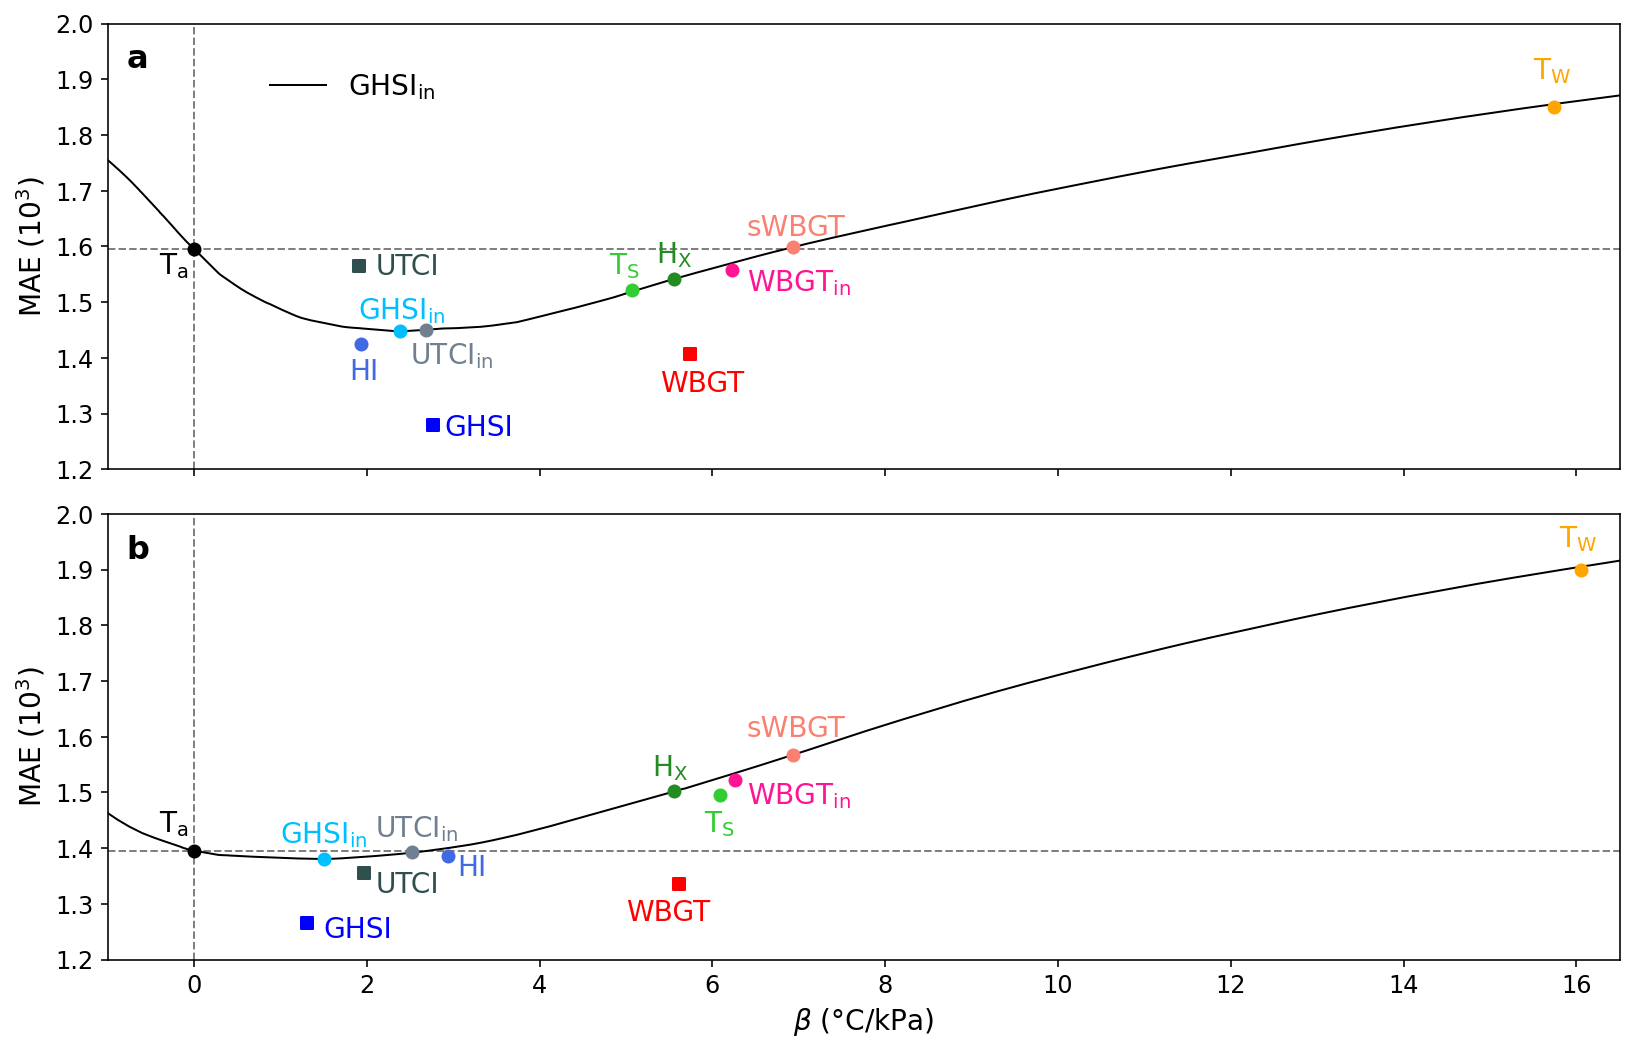

In [3]:
fig = plt.figure(figsize=(10.5,6.5))
ax1 = fig.add_subplot(2,1,1)  
ax2 = fig.add_subplot(2,1,2) 

size=120
addsize=10
linewidth=3

X=GHSI_mae.sel(beta=slice(-4,16.5))['beta'].values # x variable: beta from -4 to 16.5 C/kPa

# Panel a: Tokyo (prefecture index=13)
# MAE of GHSI indoor
ax1.plot(X,GHSI_mae.sel(exposure='indoor').sel(pf=13).sel(beta=slice(-4,16.5)),zorder=0,c='k',linewidth=1,label=r'$\mathrm{GHSI}_{\mathrm{in}}$')
# MAE of heat index
ax1.scatter(HSI_beta.sel(var='HI').sel(pf=13),HSI_mae.sel(pf=13).sel(HSI='HI'),c='royalblue')
# MAE of lethal temperature
ax1.scatter(HSI_beta.sel(var='Ts').sel(pf=13),HSI_mae.sel(pf=13).sel(HSI='Ts'),c='limegreen')
# MAE of wet-bulb temperature
ax1.scatter(HSI_beta.sel(var='Tw').sel(pf=13),HSI_mae.sel(pf=13).sel(HSI='Tw'),c='orange')
# MAE of indoor WBGT
ax1.scatter(HSI_beta.sel(var='WBGTin').sel(pf=13),HSI_mae.sel(pf=13).sel(HSI='WBGTin'),c='deeppink')
# MAE of outdoor WBGT
ax1.scatter(HSI_beta.sel(var='WBGT').sel(pf=13),HSI_mae.sel(pf=13).sel(HSI='WBGT'),c='red',marker='s')
# MAE of indoor UTCI
ax1.scatter(HSI_beta.sel(var='UTCIin').sel(pf=13),HSI_mae.sel(pf=13).sel(HSI='UTCIin'),c='slategrey')
# MAE of outdoor UTCI
ax1.scatter(HSI_beta.sel(var='UTCI').sel(pf=13),HSI_mae.sel(pf=13).sel(HSI='UTCI'),c='darkslategrey',marker='s')
# MAE of humidex; humidex is a linear combination of temperature and vapor pressure with a constant beta=50/9 C/kPa
ax1.scatter(50/9,HSI_mae.sel(pf=13).sel(HSI='Hx'),c='forestgreen')
# MAE of simplified WBGT; simplified WBGT is a linear combination of temperature and vapor pressure with a constant beta=6.93 C/kPa
ax1.scatter(6.93,HSI_mae.sel(pf=13).sel(HSI='sWBGT'),c='salmon')
# lowest MAE of GHSI indoor across a range of beta values
ax1.scatter(GHSI_mae.sel(exposure='indoor').sel(pf=13).idxmin('beta').values,
            GHSI_mae.sel(exposure='indoor').sel(pf=13).min('beta'),c='deepskyblue')
# lowest MAE of GHSI outdoor across a range of beta values
ax1.scatter(GHSI_mae.sel(exposure='outdoor').sel(pf=13).idxmin('beta').values,
            GHSI_mae.sel(exposure='outdoor').sel(pf=13).min('beta'),c='blue',marker='s')
# MAE of dry-bulb temperature
ax1.scatter(0,GHSI_mae.sel(exposure='indoor').sel(pf=13).sel(beta=0),c='k')

ax1.tick_params(axis='both', labelsize=12)
ax1.set_xlim(-1,16.5)
ax1.set_ylabel('MAE '+ '('+r'$\mathrm{10}^{\mathrm{3}}$'+')',fontsize=14)
ax1.set_xlabel(r'$\beta$ (°C/kPa)',fontsize=14)
ax1.hlines(HSI_mae.sel(pf=13).sel(HSI='Ta'), -1,16.5,color='grey', linewidth=1,linestyle='dashed',zorder=0)
ax1.vlines(0,1.2,2,color='grey', linewidth=1,linestyle='dashed',zorder=0)
ax1.set_ylim(1.2,2)

ax1.text(15.5,1.9,r'$\mathrm{T}_{\mathrm{W}}$',fontsize=14,c='orange')  
ax1.text(-0.4,1.55,r'$\mathrm{T}_{\mathrm{a}}$',fontsize=14,c='k')
ax1.text(1.8,1.36,'HI',fontsize=14,c='royalblue')
ax1.text(4.8,1.55,r'$\mathrm{T}_{\mathrm{S}}$',fontsize=14,c='limegreen')
ax1.text(6.4,1.52,r'$\mathrm{WBGT}_{\mathrm{in}}$',fontsize=14,c='deeppink')
ax1.text(5.4,1.34,'WBGT',fontsize=14,c='red')
ax1.text(2.5,1.39,r'$\mathrm{UTCI}_{\mathrm{in}}$',fontsize=14,c='slategrey')
ax1.text(2.1,1.55,'UTCI',fontsize=14,c='darkslategrey')
ax1.text(2.9,1.26,'GHSI',fontsize=14,c='blue')
ax1.text(1.9,1.47,r'$\mathrm{GHSI}_{\mathrm{in}}$',fontsize=14,c='deepskyblue')
ax1.text(5.35,1.57,r'$\mathrm{H}_{\mathrm{X}}$',fontsize=14,c='forestgreen')
ax1.text(6.4,1.62,'sWBGT',fontsize=14,c='salmon')


# Panel b: Osaka (prefecture index=27)
# MAE of GHSI indoor
ax2.plot(X,GHSI_mae.sel(exposure='indoor').sel(pf=27).sel(beta=slice(-4,16.5)),zorder=0,c='k',linewidth=1,label=r'$\mathrm{GHSI}_{\mathrm{in}}$')
# MAE of heat index
ax2.scatter(HSI_beta.sel(var='HI').sel(pf=27),HSI_mae.sel(pf=27).sel(HSI='HI'),c='royalblue')
# MAE of lethal temperature
ax2.scatter(HSI_beta.sel(var='Ts').sel(pf=27),HSI_mae.sel(pf=27).sel(HSI='Ts'),c='limegreen')
# MAE of wet-bulb temperature
ax2.scatter(HSI_beta.sel(var='Tw').sel(pf=27),HSI_mae.sel(pf=27).sel(HSI='Tw'),c='orange')
# MAE of indoor WBGT
ax2.scatter(HSI_beta.sel(var='WBGTin').sel(pf=27),HSI_mae.sel(pf=27).sel(HSI='WBGTin'),c='deeppink')
# MAE of outdoor WBGT
ax2.scatter(HSI_beta.sel(var='WBGT').sel(pf=27),HSI_mae.sel(pf=27).sel(HSI='WBGT'),c='red',marker='s')
# MAE of indoor UTCI
ax2.scatter(HSI_beta.sel(var='UTCIin').sel(pf=27),HSI_mae.sel(pf=27).sel(HSI='UTCIin'),c='slategrey')
# MAE of outdoor UTCI
ax2.scatter(HSI_beta.sel(var='UTCI').sel(pf=27),HSI_mae.sel(pf=27).sel(HSI='UTCI'),c='darkslategrey',marker='s')
# MAE of humidex; humidex is a linear combination of temperature and vapor pressure with a constant beta=50/9 C/kPa
ax2.scatter(50/9,HSI_mae.sel(pf=27).sel(HSI='Hx'),c='forestgreen')
# MAE of simplified WBGT; simplified WBGT is a linear combination of temperature and vapor pressure with a constant beta=6.93 C/kPa
ax2.scatter(6.93,HSI_mae.sel(pf=27).sel(HSI='sWBGT'),c='salmon')
# lowest MAE of GHSI indoor across a range of beta values
ax2.scatter(GHSI_mae.sel(exposure='indoor').sel(pf=27).idxmin('beta').values,
            GHSI_mae.sel(exposure='indoor').sel(pf=27).min('beta'),c='deepskyblue')
# lowest MAE of GHSI outdoor across a range of beta values
ax2.scatter(GHSI_mae.sel(exposure='outdoor').sel(pf=27).idxmin('beta').values,
            GHSI_mae.sel(exposure='outdoor').sel(pf=27).min('beta'),c='blue',marker='s')
# MAE of dry-bulb temperature
ax2.scatter(0,GHSI_mae.sel(exposure='indoor').sel(pf=27).sel(beta=0),c='k')

ax2.tick_params(axis='both', labelsize=12)

ax2.set_xlim(-1,16.5)
ax2.set_ylabel('MAE '+ '('+r'$\mathrm{10}^{\mathrm{3}}$'+')',fontsize=14)
ax2.set_xlabel(r'$\beta$ (°C/kPa)',fontsize=14)
ax2.hlines(HSI_mae.sel(pf=27).sel(HSI='Ta'), -1,16.5,color='grey', linewidth=1,linestyle='dashed',zorder=0)
ax2.vlines(0,1.2,2,color='grey', linewidth=1,linestyle='dashed',zorder=0)
ax2.set_ylim(1.2,2)

anno_opts = dict(xy=(0.02, 0.9), xycoords='axes fraction',va='baseline', ha='center')
ax1.annotate('a', **anno_opts,fontsize=16,fontweight='bold')  
ax2.annotate('b', **anno_opts,fontsize=16,fontweight='bold')  

ax2.text(15.8,1.94,r'$\mathrm{T}_{\mathrm{W}}$',fontsize=14,c='orange')  
ax2.text(-0.4,1.43,r'$\mathrm{T}_{\mathrm{a}}$',fontsize=14,c='k')
ax2.text(3.05,1.35,'HI',fontsize=14,c='royalblue')
ax2.text(5.9,1.43,r'$\mathrm{T}_{\mathrm{S}}$',fontsize=14,c='limegreen')
ax2.text(6.4,1.48,r'$\mathrm{WBGT}_{\mathrm{in}}$',fontsize=14,c='deeppink')
ax2.text(5,1.27,'WBGT',fontsize=14,c='red')
ax2.text(2.1,1.42,r'$\mathrm{UTCI}_{\mathrm{in}}$',fontsize=14,c='slategrey')
ax2.text(2.1,1.32,'UTCI',fontsize=14,c='darkslategrey')
ax2.text(1.5,1.24,'GHSI',fontsize=14,c='blue')
ax2.text(1,1.41,r'$\mathrm{GHSI}_{\mathrm{in}}$',fontsize=14,c='deepskyblue')
ax2.text(5.3,1.53,r'$\mathrm{H}_{\mathrm{X}}$',fontsize=14,c='forestgreen')
ax2.text(6.4,1.6,'sWBGT',fontsize=14,c='salmon')

ax1.legend(fontsize=14,frameon=False,loc=(0.1,0.8))
ax1.tick_params(axis='x', labelbottom=False)
ax1.set_xlabel('')
fig.subplots_adjust(bottom=0, left=0,right=1, top=1,hspace=0.1)

**Fig. S3.** Same as Fig. 4b but for (a) Tokyo and (b) Osaka.